# **Tell Me What You Want, I'll Tell You What You Like**

In this file, we try to use an approach using Neural Network 

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [7]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...


## Main code

In [8]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np

import time

In [9]:
#############################
### Essentials functions ###
#############################

import Function_NN as nn
sys.path.append("..")
import FunctionMain as fm
from Solver import *
from User import *

In [10]:
# ----------------- Parameters

# The file to consider
file = '../file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20

# Parameters of the first neural network
nb_hidden_layers = 1
nb_neurons = [3, 1]

# Parameters of the second neural network
nb_hidden_layers2 = 1
nb_neurons2 = [3, 1]


# The number of solutions that we will have in the solver after the first iteration
k_k = 10

In [11]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, tasks = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
# fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)

sol_layers = fm.list_list_list_start_of_tasks(n, m, list_layers)


--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 3880
Le max de list_obj est 5423
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x00000152A09EFAC0>], [<docplex.cp.solution.CpoSolveResult object at 0x000001529DF71AC0>, <docplex.cp.solution.CpoSolveResult object at 0x000001521B529440>, <docplex.cp.solution.CpoSolveResult object at 0x00000152A37DAAC0

In [12]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    list_weights = nn.find_perfect_NN(file, sol_layers, nb_hidden_layers, nb_neurons)

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, tasks = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

    # ---------------- Interaction with the neural network

    # Create the weights of the neural network
    weights10 = [[[model.integer_var(min=-1, max=1, name="w{}-{}-{}".format(0,j,k)) for k in range(n*m)] for j in range(nb_neurons[0])]]
    weights1 = weights10 + [[[model.integer_var(min=-1, max=1, name="w{}-{}-{}".format(i,j,k)) for k in range(nb_neurons[i-1])] for j in range(nb_neurons[i])] for i in range(1, nb_hidden_layers + 1)]
    
    for i in range(len(weights1)):
        for j in range(len(weights1[i])):
            for k in range(len(weights1[i][j])):
                model.add(weights1[i][j][k])

    if len(list_weights) == 2:
        weights20 = [[[model.integer_var(min=-1, max=1, name="w{}-{}-{}".format(0,j,k)) for k in range(n*m)] for j in range(nb_neurons[0])]]
        weights2 = weights20 + [[[model.integer_var(min=-1, max=1, name="w{}-{}-{}".format(i,j,k)) for k in range(nb_neurons[i-1])] for j in range(nb_neurons[i])] for i in range(1, nb_hidden_layers + 1)]
    
        for i in range(len(weights2)):
            for j in range(len(weights2[i])):
                for k in range(len(weights2[i][j])):
                    model.add(weights2[i][j][k])


    # Add the constraint that the weights of the neural network must be different from the previous one
        bb = model.integer_var(0,1)
        solver.add_variable(bb)
        bb=1

        list_variables = solver.get_variables()
        variables = list_variables[0]

        b = model.integer_var(0,1)
        solver.add_variable(b)
        b=0

        for i in range(len(weights1)):
            for j in range(len(weights1[i])):
                for k in range(len(weights1[i][j])):

                    b =max(b, weights1[i][j][k] != weights2[i][j][k])

        b = (b!=0)
        bb = bb * b
        solver.add_constraint(model, bb==1)


    # Compare the result of 2 different neural networks for the same solution

    tasks_starts = []
    for i in range(n):
        for j in range(m):
            tasks_starts.append(model.start_of(variables[i][j]))

    outputvar_NN1 = nn.activation_function(model, solver, tasks_starts, weights1, nb_hidden_layers, nb_neurons, optimalval)
    print(outputvar_NN1)

    if len(list_weights) == 2:
        outputvar_NN2 = nn.activation_function(model, solver, tasks_starts, weights2, nb_hidden_layers, nb_neurons, optimalval)
        print(outputvar_NN2)
        if it > 5:
            solver.add_constraint(model, outputvar_NN1 == 1)
            solver.add_constraint(model, outputvar_NN2 == 1)
        else:
            solver.add_constraint(model, outputvar_NN1 != outputvar_NN2)
    else:
        solver.add_constraint(model, outputvar_NN1 == 1)
    

    # ------------ Solve the model
    print("\nSolving the model...")
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
    print("The number of solutions generated is :",nb_solution)

    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    sol_layers = fm.list_list_list_start_of_tasks(n, m, list_layers)

    # list_min_obj_global.append(min(list_obj))
    # print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)


--------Iteration 1---------
Searching for perfect neural networks...
2 perfect neural networks found !

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
a10 = intVar(0, 1)
a10 = intVar(0, 1)

Solving the model...
The number of solutions generated is : 5419
Objective function : [3880, 3860]
Model solved !

Classing solutions...
Le min de list_obj est 3860
Le max de list_obj est 5423
Solutions classed !

Creating preferences...
Preferences created !
Il y a 20 solution(s)

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 2---------
Searching for perfect neural networks...
2 perfect neural networks found !

Creating the model variables...
Model tasks_by_jobs created !

S

Exception ignored in: <function CpoSolver.__del__ at 0x0000015252D732E0>
Traceback (most recent call last):
  File "c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\docplex\cp\solver\solver.py", line 601, in __del__
    self.end()
  File "c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\docplex\cp\solver\solver.py", line 1057, in end
    def end(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

[3880, 3860, 3863, 3866, 3869, 3872, 3875, 3878, 3881, 3884, 3887, 3890, 3893]


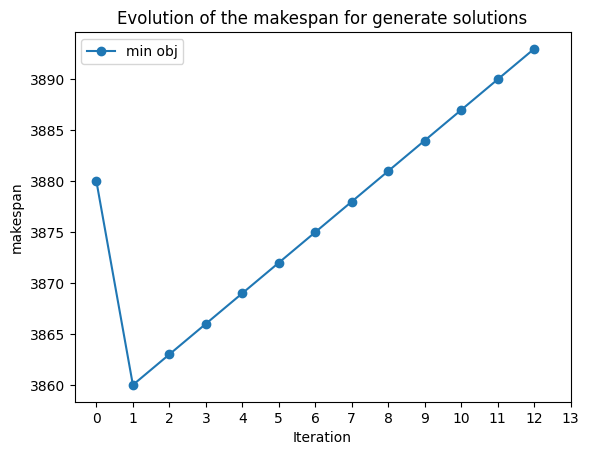

In [13]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it-1)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[3880]


ValueError: x and y must have same first dimension, but have shapes (13,) and (1,)

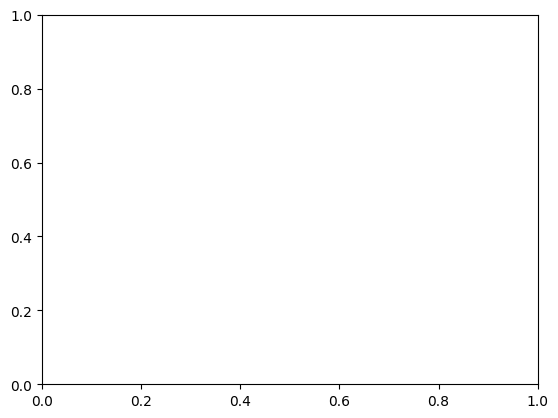

In [14]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it-1)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [ ]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m)))